In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [385]:
sbiStockData = pd.read_csv("./SBI-Stock-Price-Weekly.csv", index_col="Date", parse_dates=True)
sbiStockData.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)
sbiStockData.head(-1)

,Close
Date,
2011-10-17,194.824997
2011-10-24,190.979996
2011-10-31,196.615005
2011-11-07,179.835007
2011-11-14,172.664993
...,...
2021-09-13,454.100006
2021-09-20,440.750000
2021-09-27,451.649994


<AxesSubplot:xlabel='Date'>

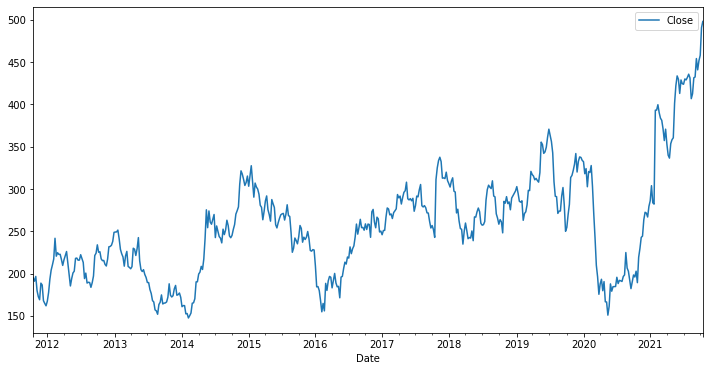

In [386]:
sbiStockData.plot(figsize=(12,6))

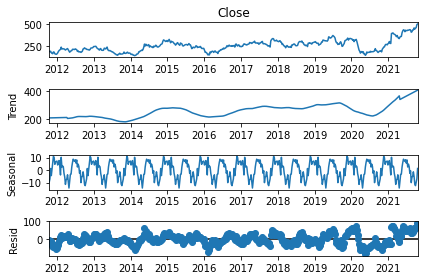

In [407]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(x=sbiStockData['Close'], extrapolate_trend='freq')

# results = seasonal_decompose(sbiStockData['Close'])
results.plot();

In [388]:
train_data_len = round(len(sbiStockData)*0.7)

train_data = sbiStockData[:train_data_len]
test_data = sbiStockData[train_data_len-steps:]

In [389]:
len(test_data)

207

In [390]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(sbiStockData)

scaled_training_data = scaler.fit_transform(train_data)
scaled_testing_data = scaler.fit_transform(test_data)
scaled_training_data

array([[0.24903943],
       [0.22880152],
       [0.25846102],
       [0.17014059],
       [0.13240169],
       [0.11342704],
       [0.21672194],
       [0.2055108 ],
       [0.10737412],
       [0.0907153 ],
       [0.07576716],
       [0.10403178],
       [0.15842942],
       [0.24093377],
       [0.29764725],
       [0.33057006],
       [0.36675617],
       [0.49578928],
       [0.38449393],
       [0.40612664],
       [0.39544188],
       [0.39623136],
       [0.36404551],
       [0.32699089],
       [0.36183488],
       [0.38802042],
       [0.41336387],
       [0.34233384],
       [0.27430393],
       [0.19922104],
       [0.24498656],
       [0.2799095 ],
       [0.29114691],
       [0.37073009],
       [0.3726512 ],
       [0.35933471],
       [0.3599663 ],
       [0.39346809],
       [0.37020372],
       [0.34575504],
       [0.24522348],
       [0.27909368],
       [0.21719563],
       [0.22209067],
       [0.22040633],
       [0.19066796],
       [0.21945895],
       [0.261

In [391]:
steps = 50

X_train = []
y_train = []
for i in range(steps, len(scaled_training_data)):
    X_train.append(scaled_training_data[i-steps:i, 0])
    y_train.append(scaled_training_data[i,0])
X_train

[array([0.24903943, 0.22880152, 0.25846102, 0.17014059, 0.13240169,
        0.11342704, 0.21672194, 0.2055108 , 0.10737412, 0.0907153 ,
        0.07576716, 0.10403178, 0.15842942, 0.24093377, 0.29764725,
        0.33057006, 0.36675617, 0.49578928, 0.38449393, 0.40612664,
        0.39544188, 0.39623136, 0.36404551, 0.32699089, 0.36183488,
        0.38802042, 0.41336387, 0.34233384, 0.27430393, 0.19922104,
        0.24498656, 0.2799095 , 0.29114691, 0.37073009, 0.3726512 ,
        0.35933471, 0.3599663 , 0.39346809, 0.37020372, 0.34575504,
        0.24522348, 0.27909368, 0.21719563, 0.22209067, 0.22040633,
        0.19066796, 0.21945895, 0.2612769 , 0.38849418, 0.40291595]),
 array([0.22880152, 0.25846102, 0.17014059, 0.13240169, 0.11342704,
        0.21672194, 0.2055108 , 0.10737412, 0.0907153 , 0.07576716,
        0.10403178, 0.15842942, 0.24093377, 0.29764725, 0.33057006,
        0.36675617, 0.49578928, 0.38449393, 0.40612664, 0.39544188,
        0.39623136, 0.36404551, 0.32699089, 0.

In [392]:
y_train

[0.4549450482934615,
 0.4087847042269407,
 0.4119427177234928,
 0.36751939661246913,
 0.35651875476291484,
 0.35788730043983097,
 0.33335967331544614,
 0.3233854433552964,
 0.36591400689736286,
 0.44270749927081676,
 0.44483918509292086,
 0.45231333090390724,
 0.4760250519494432,
 0.5324490780449213,
 0.5347386616469639,
 0.5352650367054835,
 0.54666033615821,
 0.4933154562525538,
 0.42689093039394355,
 0.3991526080543025,
 0.37944107112371517,
 0.32241171844803096,
 0.38654666070459853,
 0.4141796932949183,
 0.32046427389693466,
 0.3145691743099853,
 0.30612138254325527,
 0.3193325775216437,
 0.43399651997482713,
 0.42783831181013954,
 0.3888099797670935,
 0.4308121682506404,
 0.49989474972643955,
 0.3558608254155263,
 0.3008842912552162,
 0.2889888760200833,
 0.3004106031788355,
 0.2705405950170904,
 0.25196067551027224,
 0.22072220062313275,
 0.2201694820735438,
 0.17695672990797595,
 0.1527185548523986,
 0.10816360050098428,
 0.09950522397217687,
 0.05026581793079066,
 0.0442128995

In [393]:
X_test = []
y_test = scaled_data[train_data_len:,:]
for i in range(steps, len(scaled_testing_data)):
    X_test.append(scaled_testing_data[i-steps:i, 0])
len(X_test)

157

In [394]:
len(y_test)

157

In [395]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_train.shape)
print(X_test.shape)

(316, 50)
(157, 50)


In [396]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(316, 50, 1)
(157, 50, 1)


In [397]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [398]:
model=Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [399]:
model.fit(X_train, y_train, batch_size=64, epochs=100)

Epoch 1/100
5/5 [==============================] - 3s 69ms/step - loss: 0.2210
Epoch 2/100
5/5 [==============================] - 0s 68ms/step - loss: 0.0632
Epoch 3/100
5/5 [==============================] - 0s 62ms/step - loss: 0.0358
Epoch 4/100
5/5 [==============================] - 0s 66ms/step - loss: 0.0385
Epoch 5/100
5/5 [==============================] - 0s 64ms/step - loss: 0.0293
Epoch 6/100
5/5 [==============================] - 0s 68ms/step - loss: 0.0279
Epoch 7/100
5/5 [==============================] - 0s 63ms/step - loss: 0.0259
Epoch 8/100
5/5 [==============================] - 0s 67ms/step - loss: 0.0239
Epoch 9/100
5/5 [==============================] - 0s 62ms/step - loss: 0.0225
Epoch 10/100
5/5 [==============================] - 0s 63ms/step - loss: 0.0221
Epoch 11/100
5/5 [==============================] - 0s 63ms/step - loss: 0.0213
Epoch 12/100
5/5 [==============================] - 0s 64ms/step - loss: 0.0202
Epoch 13/100
5/5 [==============================]

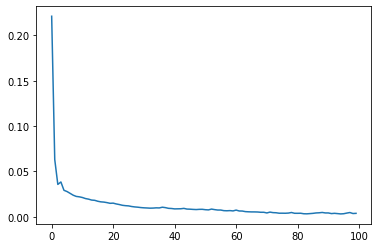

In [400]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [401]:
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)
test_predictions

array([[262.73724],
       [254.8989 ],
       [265.20786],
       [274.58704],
       [281.99445],
       [281.091  ],
       [278.4664 ],
       [272.13135],
       [273.92963],
       [279.0863 ],
       [284.6233 ],
       [289.4958 ],
       [294.74973],
       [294.33392],
       [287.90237],
       [282.3251 ],
       [280.48853],
       [269.38373],
       [264.26108],
       [264.1416 ],
       [269.23227],
       [281.4246 ],
       [289.63785],
       [303.54144],
       [310.80698],
       [311.56018],
       [308.14658],
       [306.30133],
       [305.14267],
       [304.2743 ],
       [309.68774],
       [331.16937],
       [344.52008],
       [343.934  ],
       [341.51794],
       [343.58527],
       [352.54623],
       [363.9597 ],
       [366.68643],
       [362.85995],
       [353.93723],
       [331.83456],
       [311.65164],
       [303.43555],
       [290.21796],
       [284.2852 ],
       [282.23633],
       [290.92523],
       [301.29874],
       [292.87985],


/var/folders/83/4vs_8v5s7hz9x17bfyd6h90m0000gq/T/ipykernel_38163/3877976180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_rep['predictions'] = test_predictions


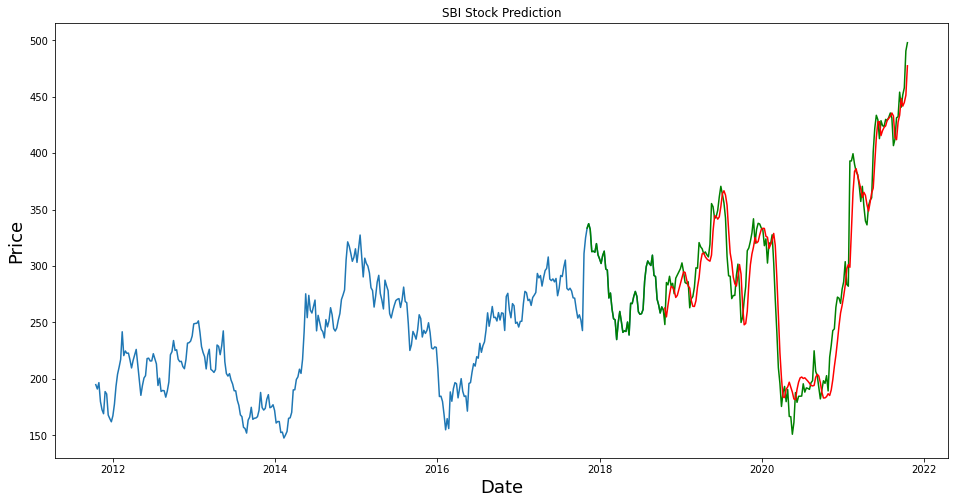

In [402]:
test_data_rep = sbiStockData[train_data_len:]
test_data_rep['predictions'] = test_predictions

plt.figure(figsize=(16,8))
plt.title("SBI Stock Prediction")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.plot(train_data['Close'])
plt.plot(test_data['Close'], "g")
plt.plot(test_data_rep['predictions'], "r")
plt.show()

In [403]:
first_eval_batch = scaled_testing_data[steps-steps:steps, 0]
current_batch = first_eval_batch.reshape((1, steps, 1))

test_predictions = []

for i in range(len(test_data_rep)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

test_predictions

[array([0.32234865], dtype=float32),
 array([0.31973317], dtype=float32),
 array([0.31474924], dtype=float32),
 array([0.30607656], dtype=float32),
 array([0.29379576], dtype=float32),
 array([0.27857924], dtype=float32),
 array([0.26110697], dtype=float32),
 array([0.2422137], dtype=float32),
 array([0.22275516], dtype=float32),
 array([0.20333369], dtype=float32),
 array([0.18456215], dtype=float32),
 array([0.16712825], dtype=float32),
 array([0.15154815], dtype=float32),
 array([0.13863248], dtype=float32),
 array([0.12863465], dtype=float32),
 array([0.12186579], dtype=float32),
 array([0.11751163], dtype=float32),
 array([0.11513726], dtype=float32),
 array([0.11400509], dtype=float32),
 array([0.11333388], dtype=float32),
 array([0.11262745], dtype=float32),
 array([0.11153494], dtype=float32),
 array([0.1099226], dtype=float32),
 array([0.1078077], dtype=float32),
 array([0.10525105], dtype=float32),
 array([0.10228822], dtype=float32),
 array([0.09902899], dtype=float32),
 arr

In [404]:
len(test_predictions)

157

In [405]:
true_predictions = scaler.inverse_transform(test_predictions)

/var/folders/83/4vs_8v5s7hz9x17bfyd6h90m0000gq/T/ipykernel_38163/4075775447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_rep['true_pred'] = true_predictions


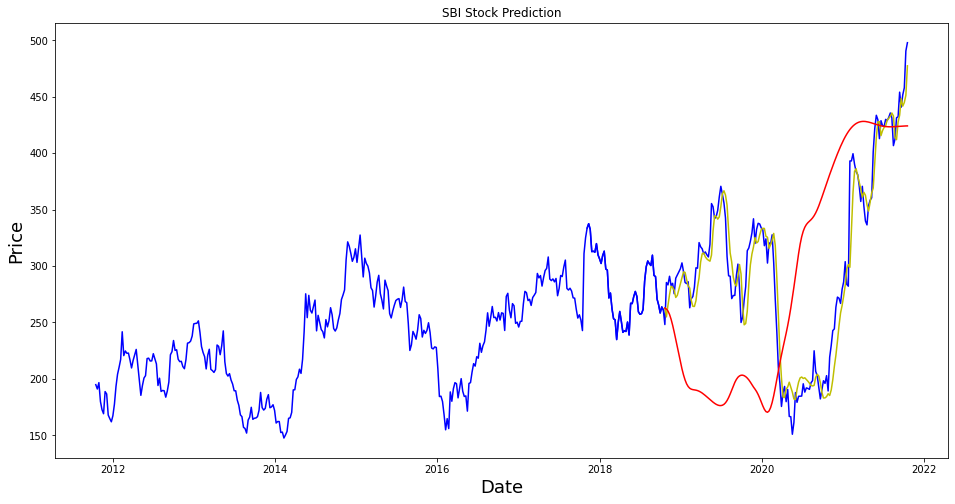

In [411]:
test_data_rep['true_pred'] = true_predictions

plt.figure(figsize=(16,8))
plt.title("SBI Stock Prediction")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.plot(train_data['Close'], "b")
plt.plot(test_data['Close'], "b")
plt.plot(test_data_rep['predictions'], "y")
plt.plot(test_data_rep['true_pred'], "r")
plt.show()